In [33]:
import cv2
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import random

import os
import rasterio
import shapely.geometry

#%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

In [34]:
#!ls /home/ubuntu/data/TX_post/*.tif

In [75]:
# Tell the script where to look for images
path_to_harvey_images = '/home/ubuntu/data/TX_post/'

# Load the shapefile with the flooding
file = '/home/ubuntu/data/vector_data/Flood_Analysis_shapefile/20170831_130614_Flood_Analysis.shp'
#file = 'digitalglobe_crowdsourcing_hurricane_harvey_raw_results_20170905.geojson'
flooding = gpd.read_file(file)


# Convert the CRS of the flooding file
flooding.to_crs({'init': 'epsg:4326'}, inplace=True)

In [77]:
flooding.head()

,ID,Latitude,Longitude,Area_KM,Comment,geometry
0,17,30.436438,-95.527609,0.001094,Flood Extraction: derived from RADARSAT-2 new ...,"POLYGON ((-95.5276346461345 30.43616575670645,..."
1,26,30.435607,-95.477129,0.002031,Flood Extraction: derived from RADARSAT-2 new ...,POLYGON ((-95.47712562533235 30.43521799090599...
2,43,30.432520,-95.459499,0.001602,Flood Extraction: derived from RADARSAT-2 new ...,POLYGON ((-95.45948618003833 30.43228203449087...
3,54,30.430833,-95.453894,0.002227,Flood Extraction: derived from RADARSAT-2 new ...,POLYGON ((-95.45378235004287 30.43052907764439...
4,56,30.429961,-95.453775,0.001094,Flood Extraction: derived from RADARSAT-2 new ...,"POLYGON ((-95.45363254287464 30.4297426486536,..."


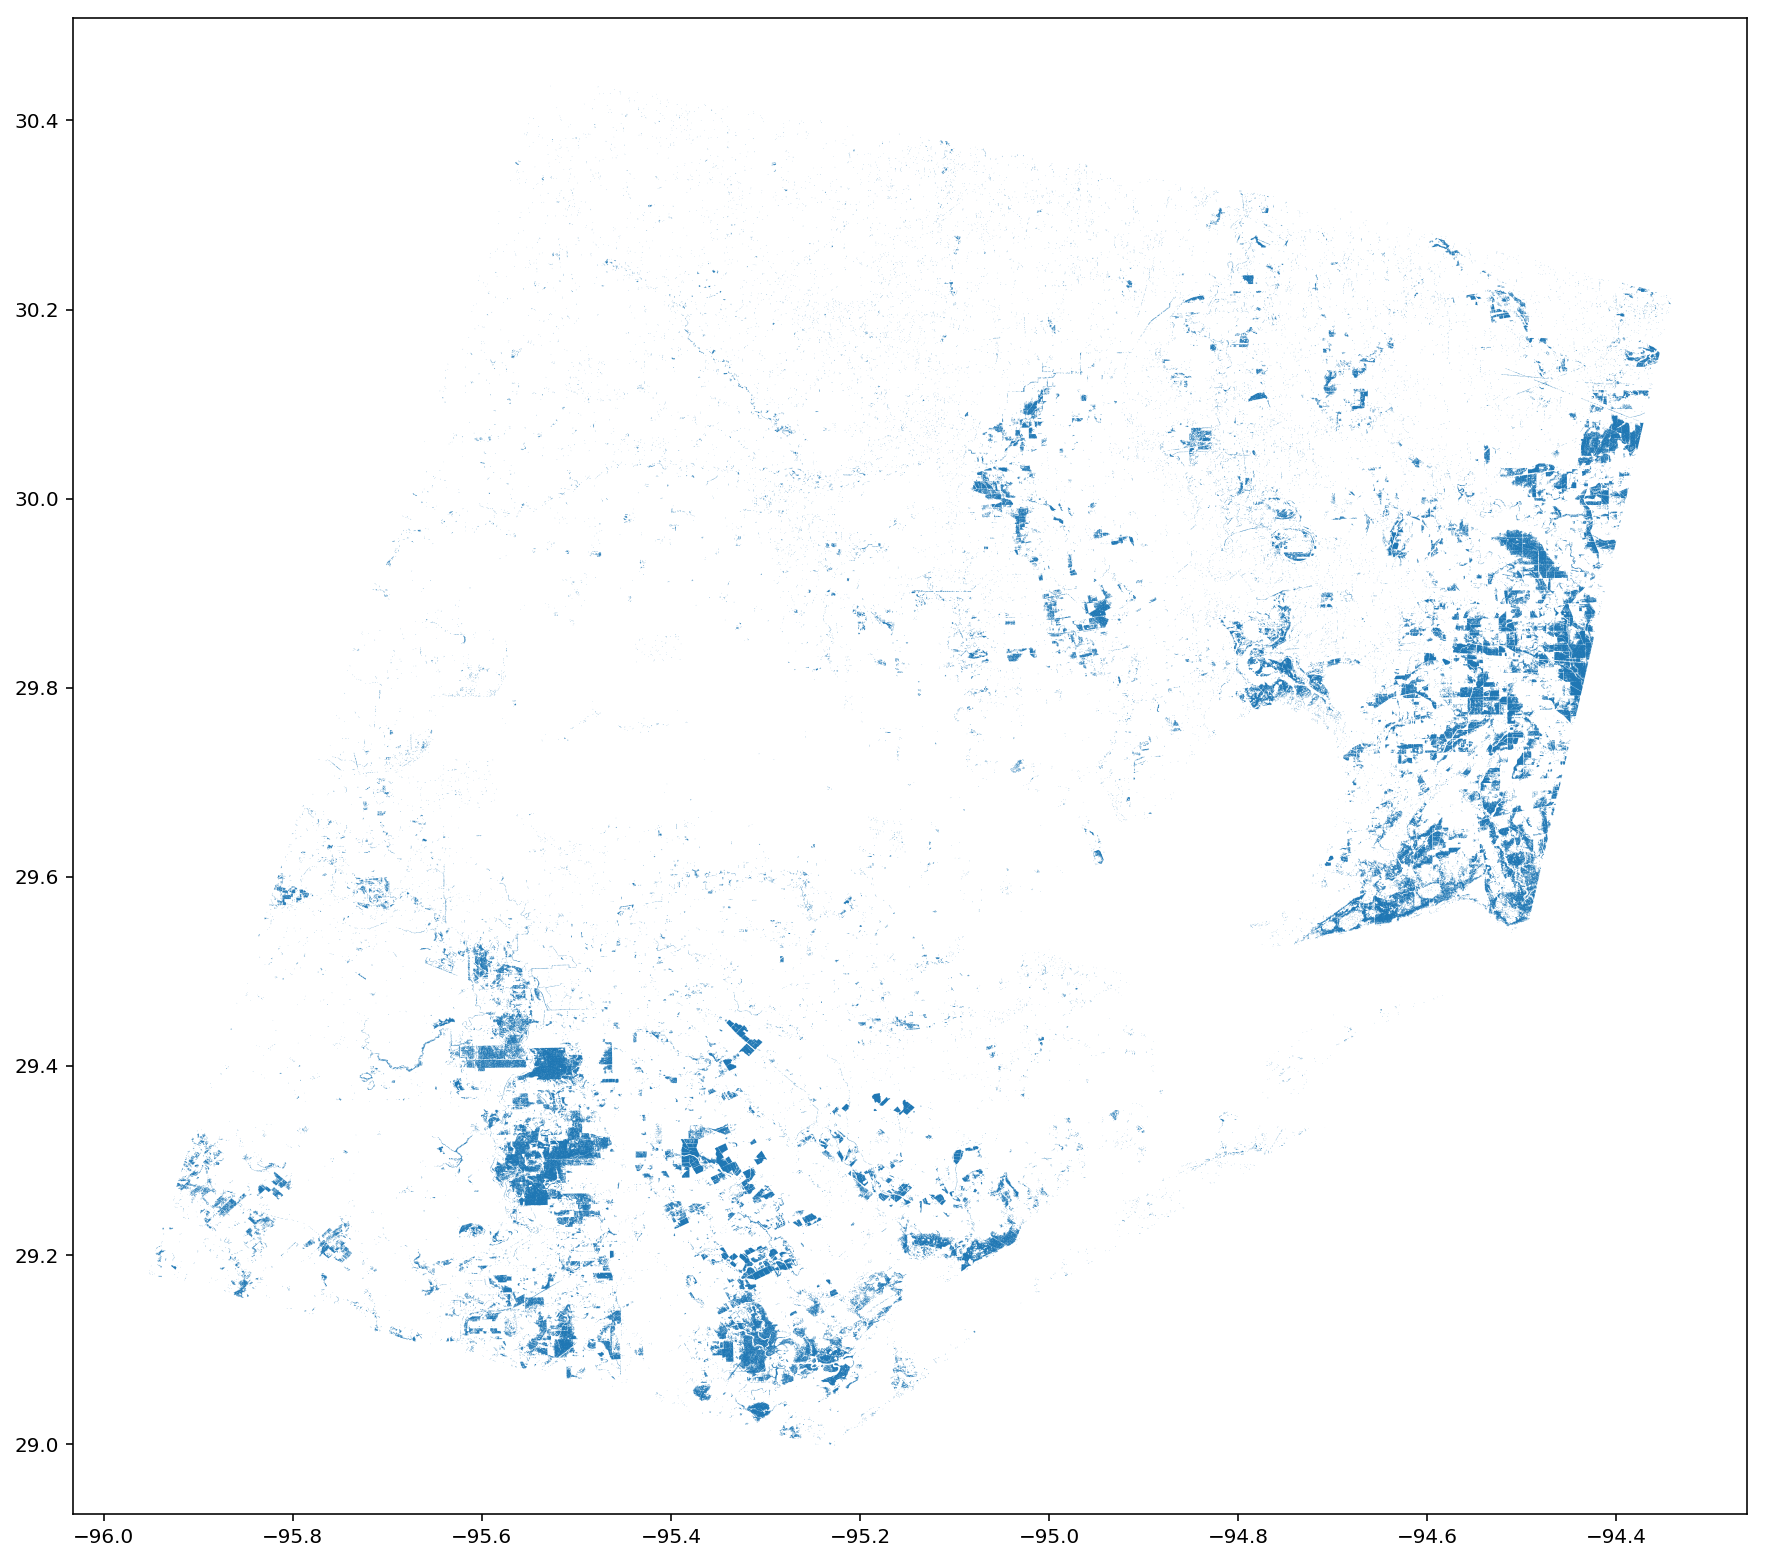

In [80]:
#flooding.plot(figsize=(15,15))

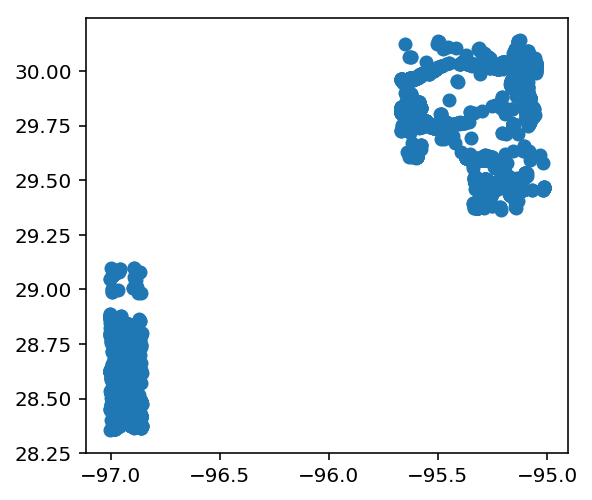

In [74]:
#flooding.plot()

In [60]:
# Get a list of all of the tif files
tif_files = [os.path.join(path_to_harvey_images, fn) for fn in os.listdir(path_to_harvey_images) if fn.endswith('tif')]
tif_files[:3]

['/home/ubuntu/data/TX_post/3020333.tif',
 '/home/ubuntu/data/TX_post/3020133.tif',
 '/home/ubuntu/data/TX_post/3002220.tif']

In [61]:
# Get the shape of each image
geometry = []
for tif_file in tif_files:
    with rasterio.open(tif_file) as src:
        geometry.append(shapely.geometry.box(*src.bounds))

In [62]:
# Create a GeoDataFrame with the image footprints
footprints = gpd.GeoDataFrame({'file_name': tif_files}, geometry=geometry, crs={'init': 'epsg:4326'})

In [63]:
# Filter for just the images that have flooding in them (I know I sqeezed a lot into one line)
footprints_with_flooding = footprints[footprints.index.isin(gpd.sjoin(flooding, footprints, how='inner', op='intersects').index_right.unique())]

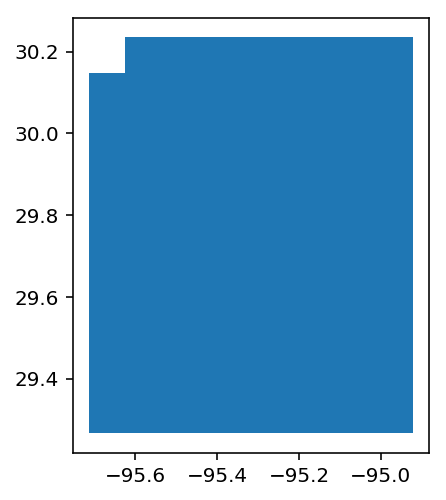

In [79]:
#footprints_with_flooding.plot()

Set up a bunch of helper functions

In [41]:
def tile_image(file_name, tile_size):
    src = rasterio.open(file_name)
    
    width = src.width
    height = src.height
    
    for i in range(0, width - tile_size, tile_size):
        for j in range(0, height - tile_size, tile_size):
            window = ((j, j + tile_size), (i, i + tile_size))
            
            # Load the tile
            img = src.read(window=window).transpose([1,2,0])
            
            # Get metadata about the tile
            transform = list(np.array(~src.window_transform(window))[[0, 1, 3, 4, 2, 5]])
            box = shapely.geometry.box(*src.window_bounds(window))
            
            # Skip any image with more than 10% missing pixels
            #print((img == 0).all(axis=2).sum() / (1.0*img.size))
            if (img == 0).all(axis=2).sum() / (1.0*img.size) > 0.1:
                continue
                
            yield img, transform, box

def polycoords(poly):
    """Convert a polygon into the format expected by OpenCV
    """
    if poly.type in ['MultiPolygon', 'GeometryCollection']:
        return [np.array(p.exterior.coords) for p in poly if p.type == 'Polygon']
    elif poly.type == 'Polygon':
        return [np.array(poly.exterior.coords)]
    else:
        print('Encountered unrecognized geometry type {}. Ignoring.'.format(poly.type))
        return []

def make_mask(img_shape, poly):
    """Make a mask from a polygon"""
    poly_pts = polycoords(poly)
    polys = [x.astype(int) for x in poly_pts]
    # Create an empty mask and then fill in the polygons
    mask = np.zeros(img_shape[:2])
    cv2.fillPoly(mask, polys, 255)
    return mask.astype('uint8')

def get_mask(mask_poly, img_shape, transform):
    # Transform the poly into image coords
    mask_poly_pxcoords = shapely.affinity.affine_transform(mask_poly, transform)
    
    # Add a buffer to pad it out a little
    mask_poly_pxcoords = mask_poly_pxcoords.buffer(2)
    
    return make_mask(img_shape, mask_poly_pxcoords)

In [42]:
print(len(footprints_with_flooding),"files with flooding found")

(59, 'files with flooding found')


In [43]:
# Start Iterating through tiles

#os.makedirs('/home/ubuntu/data/TX_post/training_tiles')

In [84]:
print("everything prepped, starting sub-image extraction")
tiles = []
tile_no = 0
control = 0
image_width = 512
for i, row in footprints_with_flooding.iterrows():
    print("file ",i,row.file_name,"Tile count starts at",tile_no)
    for tile_img, tile_transform, tile_box in tile_image(row.file_name, image_width):
        
        # Skip tiles with no flooding (you can try keeping them)
        #keep a SMALL percentage of the unflooded tiles for training (do rest of loop), but reject the rest if not flooded
        mask_poly = flooding[flooding.intersects(tile_box)].intersection(tile_box).unary_union
            
        if mask_poly.area < 1e-12:
            #print("no flooding on tile ",tile_no)
            p_keep = 0.01    #dataset could have almost 200000 512x512 images, P==0.01 should give ~2000 back
            dice_roll = np.random.random()
            if dice_roll < p_keep:
                
                mask = np.zeros(tile_img.shape[:2])
                print(str(control)+"th unflooded tile added, tile no:",tile_no)
                np.save("/home/ubuntu/data/TX_post/training_tiles/%d_mask"%tile_no, mask)
                np.save("/home/ubuntu/data/TX_post/training_tiles/%d_img"%tile_no, tile_img)
                control += 1
                tile_no += 1
        
            continue
        
        mask = get_mask(mask_poly, tile_img.shape[:2], tile_transform)
        
        # skip tiles between 0 and 5% flooding (too many false-positives)
        
        if (mask.sum()/255.)/(mask.shape[0]*mask.shape[1]) < 0.05:
            print("flooding found, but less than 5%, rejecting image")
            continue
        
        print("flooding found, tile no:",tile_no)
        np.save("/home/ubuntu/data/TX_post/training_tiles/%d_mask"%tile_no, mask)
        np.save("/home/ubuntu/data/TX_post/training_tiles/%d_img"%tile_no, tile_img)
        tile_no += 1
        #if tile_no > 20: break

everything prepped, starting sub-image extraction
('file ', 5, '/home/ubuntu/data/TX_post/3020330.tif', 'Tile count starts at', 0)
flooding found, but less than 5\%, rejecting image
flooding found, but less than 5\%, rejecting image
flooding found, but less than 5\%, rejecting image
flooding found, but less than 5\%, rejecting image
flooding found, but less than 5\%, rejecting image
('0th unflooded tile added, tile no:', 0)
('flooding found, tile no:', 1)
flooding found, but less than 5\%, rejecting image
flooding found, but less than 5\%, rejecting image
flooding found, but less than 5\%, rejecting image
flooding found, but less than 5\%, rejecting image
('flooding found, tile no:', 2)
flooding found, but less than 5\%, rejecting image
('1th unflooded tile added, tile no:', 3)
flooding found, but less than 5\%, rejecting image
flooding found, but less than 5\%, rejecting image
flooding found, but less than 5\%, rejecting image
flooding found, but less than 5\%, rejecting image
floodin

KeyboardInterrupt: 

In [15]:
tile_no = 935
#%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

524


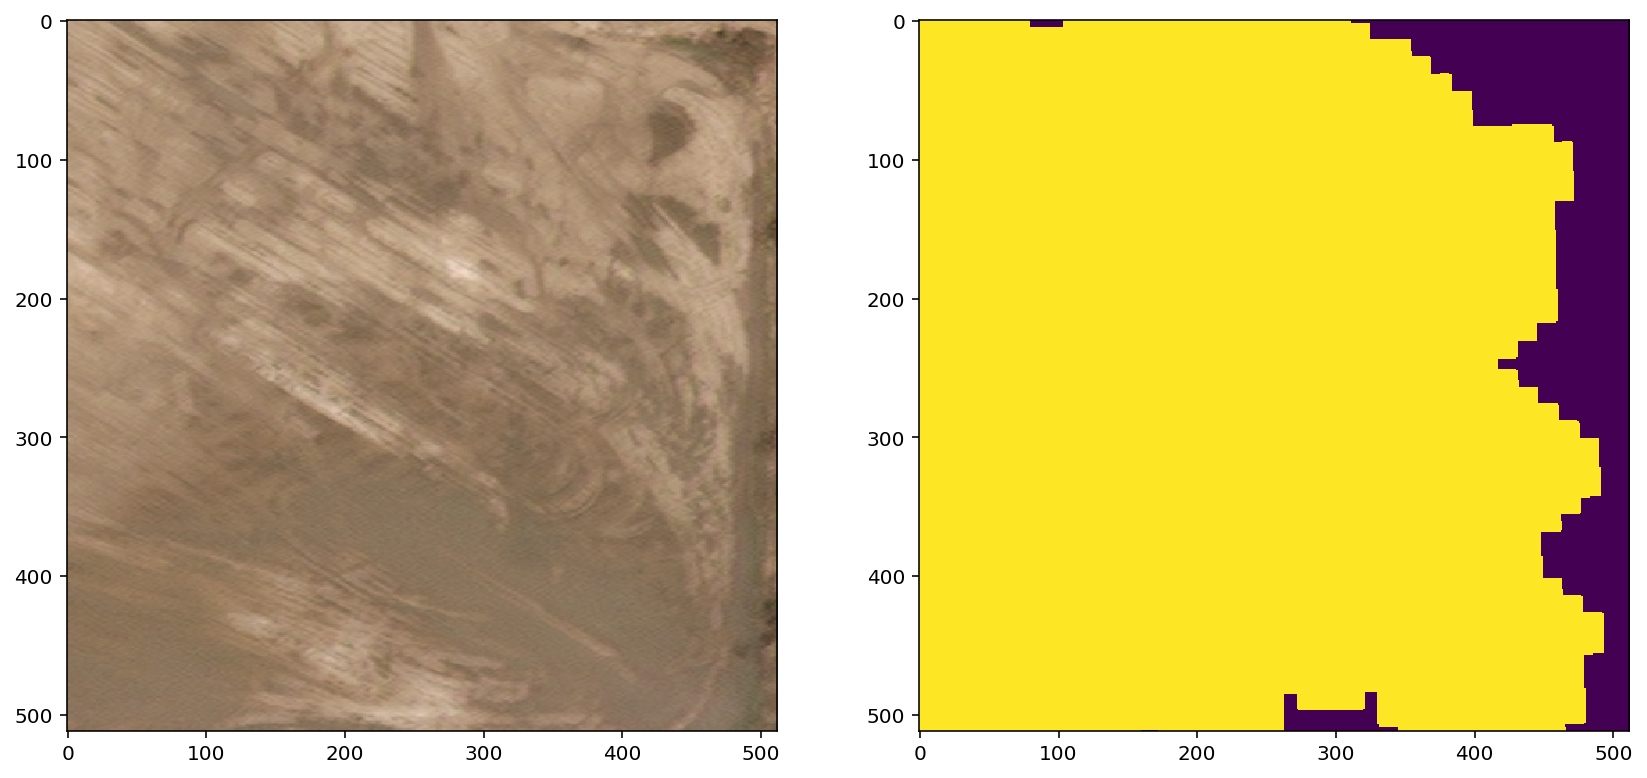

In [21]:
tile_pick = random.randint(0,tile_no-1)  #chooses a random tiletile_no = tile_no + 73
print(tile_pick)
img = np.load('/home/ubuntu/data/TX_post/training_tiles/%d_img.npy'%tile_pick)
mask = np.load('/home/ubuntu/data/TX_post/training_tiles/%d_mask.npy'%tile_pick)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,14))
ax1.imshow(img)
ax2.imshow(mask);